# Projet - Prédire les émissions de CO2 et la consommation totale d’énergie  

# Résumé 
La ville de Seattle a comme objectif de devenir une ville neutre en émissions de carbone en 2050. Pour cela, elle, s’intéresse de près aux émissions des bâtiments non destinés à l’habitation. Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir

Donc la ville cherche à prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées
à partir de ceux déjà réalisés. Les prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction) La ville cherche egalement à evaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions (qui est fastidieux à calculer avec l’approche actuelle)

# 2. Chargement des bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import copy
import seaborn as sns
import folium

from zipfile import ZipFile
from pathlib import Path

from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# 3.Données utilisées

In [2]:
pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

dir_data = Path('../../DATA/P4/') 
dir_fig  = Path('../../FIGURES/P4/')
file_in    = Path(str(dir_data) + "/archive.zip")
work_dir=os.getcwd()

file1= Path(str(dir_data) + "/2015-building-energy-benchmarking.csv")
file2=Path(str(dir_data) + "/2016-building-energy-benchmarking.csv")

Numerical_data=Path(str(dir_data) + "/Numerical_data.csv")
Categorical_data=Path(str(dir_data) + "/Categoricalcal_data.csv")

if file1.exists ():
    print ("Fichier existe")
else:
    with ZipFile(file_in, 'r') as zip:
        zip.printdir()
        zip.extractall()
        for f in os.listdir(work_dir):
            if f.endswith('.csv'):
                shutil.move(os.path.join(work_dir,f),dir_data)
            if f.endswith('.json'):
                shutil.move(os.path.join(work_dir,f),dir_data)

Fichier existe


## Fusion les fichiers 2015 et 2016
Dans cette partie, on fusionne les fichier 2015 et 2016 pour faciliter les analyses.

In [3]:
# Trouvez les différences entre les deux fichiers
T_file=[file1,file2]
var=[]
for l in T_file:
    df =pd.read_csv(l)
    var.append(df.columns)

diff =list(set(var[0])^set(var[1]))
print(diff)


['City', 'City Council Districts', 'State', 'OtherFuelUse(kBtu)', 'Zip Codes', 'GHGEmissionsIntensity', 'Comment', 'Location', 'Seattle Police Department Micro Community Policing Plan Areas', 'Comments', 'TotalGHGEmissions', 'GHGEmissions(MetricTonsCO2e)', '2010 Census Tracts', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Latitude', 'SPD Beats', 'ZipCode', 'Address', 'Longitude']


In [4]:
# Renommer les colonnes suivantes 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Comments', 'ZipCode' dans le fichier 2016
df_2016=pd.read_csv(file2).rename(columns={"TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)", \
                      "GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)",\
                      "Comments":"Comment", "ZipCode":"Zip Codes"})

# Creer un dataframe avec les coordonees des infrastructures et l'émission de CO2 pour la representation spatielle
Coordonee_geographique=copy.deepcopy(df_2016)
Coordonee_geographique.drop(Coordonee_geographique.columns.difference(['Latitude','Longitude',"GHGEmissions(MetricTonsCO2e)"]), 1, inplace=True) 

In [5]:
# Supprimez les différences, après avoir renommé les noms des variables similaires

var2=[]
for df in [pd.read_csv(file1),df_2016]:
    var2.append(df.columns)

diff_2015 =list(set(var2[0])-set(var2[1]))
diff_2016 =list(set(var2[1])-set(var2[0]))

print(diff_2015)
print(diff_2016)

df_2015=pd.read_csv(file1).drop(diff_2015,axis=1)
df_2016=df_2016.drop(diff_2016,axis=1)

['SPD Beats', 'Location', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'OtherFuelUse(kBtu)', '2010 Census Tracts']
['Latitude', 'City', 'State', 'Address', 'Longitude']


In [6]:
# Vérifier si tout va bien, s'il y a encore des variables différentes

var3=[]
for df in [df_2015,df_2016]:
    var3.append(df.columns)

diff =list(set(var3[0])^set(var3[1]))
if diff != "":
    print ("diff est vide, donc il n'y a pas de différence dans les noms des colonnes") 

diff est vide, donc il n'y a pas de différence dans les noms des colonnes


In [7]:
# Fusionner les fichiers
frames = [df_2015, df_2016]
df = pd.concat(frames)
df.index =range(0,len(df))

In [8]:
df.shape

(6716, 41)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      6716 non-null   int64  
 1   DataYear                           6716 non-null   int64  
 2   BuildingType                       6716 non-null   object 
 3   PrimaryPropertyType                6716 non-null   object 
 4   PropertyName                       6716 non-null   object 
 5   TaxParcelIdentificationNumber      6714 non-null   object 
 6   CouncilDistrictCode                6716 non-null   int64  
 7   Neighborhood                       6716 non-null   object 
 8   YearBuilt                          6716 non-null   int64  
 9   NumberofBuildings                  6708 non-null   float64
 10  NumberofFloors                     6708 non-null   float64
 11  PropertyGFATotal                   6716 non-null   int64

In [10]:
BuildingType= df['BuildingType'].unique()
print(BuildingType)
df.drop(df.loc[df['BuildingType'].str.startswith('Multifamily')].index, inplace=True)

['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Multifamily LR (1-4)' 'Campus'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [11]:
### Convert int variables into float
for col_name in df.columns:
    if df[col_name].dtype==np.int64:
        df[col_name] = df[col_name].astype(np.float64)

## Descriptive des données initial

In [12]:
desc= df.describe(include='all')
desc

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,Zip Codes
count,3318.00,3318.0,3318,3318,3318,3317,3318.00,3318,3318.00,3316.00,3310.00,3.32e+03,3318.00,3.32e+03,3255,3247,3.25e+03,1667,1667.00,684,684.00,188,2211.00,3308.00,3308.00,3309.00,3309.00,3.31e+03,3.31e+03,3.31e+03,3.31e+03,3.31e+03,3.31e+03,3.31e+03,3309.00,3309.00,3317,12,3318,48,3302.00
unique,NaN,NaN,5,30,3204,1835,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,387,57,NaN,47,NaN,40,NaN,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,4,4,NaN
top,NaN,NaN,NonResidential,Small- and Mid-Sized Office,WAREHOUSE,3224049012,NaN,DOWNTOWN,NaN,NaN,NaN,NaN,NaN,NaN,Office,Office,NaN,Parking,NaN,Office,NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Under construction starting 6/2013 (old buildi...,Compliant,Low Outlier,NaN
freq,NaN,NaN,2921,588,9,10,NaN,728,NaN,NaN,NaN,NaN,NaN,NaN,269,975,NaN,649,NaN,95,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1580,1,3198,17,NaN
mean,15951.82,2015.5,NaN,NaN,NaN,NaN,4.37,NaN,1961.54,1.12,4.13,1.16e+05,13303.30,1.02e+05,NaN,NaN,9.54e+04,NaN,36144.70,NaN,14059.48,NaN,64.82,71.61,74.83,175.44,178.66,8.07e+06,7.99e+06,4.93e+05,1.65e+06,5.64e+06,1.88e+04,1.88e+06,177.04,1.48,NaN,NaN,NaN,NaN,58468.28
std,13411.90,0.5,NaN,NaN,NaN,NaN,2.20,NaN,32.71,2.22,6.57,2.51e+05,43596.62,2.34e+05,NaN,NaN,2.27e+05,NaN,68243.54,NaN,32754.91,NaN,28.55,72.37,73.83,180.79,180.63,2.53e+07,2.07e+07,5.23e+06,5.10e+06,1.74e+07,7.90e+04,7.90e+06,666.44,2.21,NaN,NaN,NaN,NaN,39680.79
min,1.00,2015.0,NaN,NaN,NaN,NaN,1.00,NaN,1900.00,0.00,0.00,1.13e+04,-2.00,-5.06e+04,NaN,NaN,5.66e+03,NaN,0.00,NaN,0.00,NaN,1.00,0.00,0.00,-2.00,-2.10,0.00e+00,0.00e+00,0.00e+00,-3.38e+04,-1.15e+05,0.00e+00,0.00e+00,-0.80,-0.02,NaN,NaN,NaN,NaN,17916.00
25%,579.00,2015.0,NaN,NaN,NaN,NaN,2.00,NaN,1930.00,1.00,1.00,2.95e+04,0.00,2.85e+04,NaN,NaN,2.55e+04,NaN,5400.00,NaN,2626.25,NaN,47.00,33.20,35.90,76.20,80.80,1.22e+06,1.33e+06,0.00e+00,2.12e+05,7.24e+05,0.00e+00,0.00e+00,19.72,0.27,NaN,NaN,NaN,NaN,18390.00
50%,21122.00,2016.0,NaN,NaN,NaN,NaN,4.00,NaN,1965.00,1.00,2.00,4.92e+04,0.00,4.74e+04,NaN,NaN,4.32e+04,NaN,12102.00,NaN,6000.00,NaN,72.00,51.70,54.80,131.30,134.80,2.51e+06,2.69e+06,0.00e+00,4.76e+05,1.62e+06,4.80e+03,4.80e+05,49.16,0.78,NaN,NaN,NaN,NaN,98008.50
75%,24556.75,2016.0,NaN,NaN,NaN,NaN,7.00,NaN,1989.00,1.00,4.00,1.05e+05,0.00,9.45e+04,NaN,NaN,9.00e+04,NaN,31190.50,NaN,12400.00,NaN,89.00,81.70,86.12,204.90,207.80,6.92e+06,7.18e+06,0.00e+00,1.43e+06,4.88e+06,1.47e+04,1.47e+06,138.87,1.76,NaN,NaN,NaN,NaN,98109.00


In [13]:
def plot_box_plot(df,xlabel_name,ylabel_name,figure_name):
    color = dict(boxes='black', whiskers='black', medians='red', caps='black')
    ax = df.plot.box(color=color,whiskerprops = dict(linestyle='-',linewidth=2.0, color='black'),figsize=(24, 8),fontsize=18)
    ax.set_xlabel(xlabel_name,fontsize=18)
    ax.set_ylabel(ylabel_name,fontsize=18)
    plt.grid(color='k', linestyle='-', linewidth=.1)
    plt.xticks(rotation=90)
    ax.label_outer() 
    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')


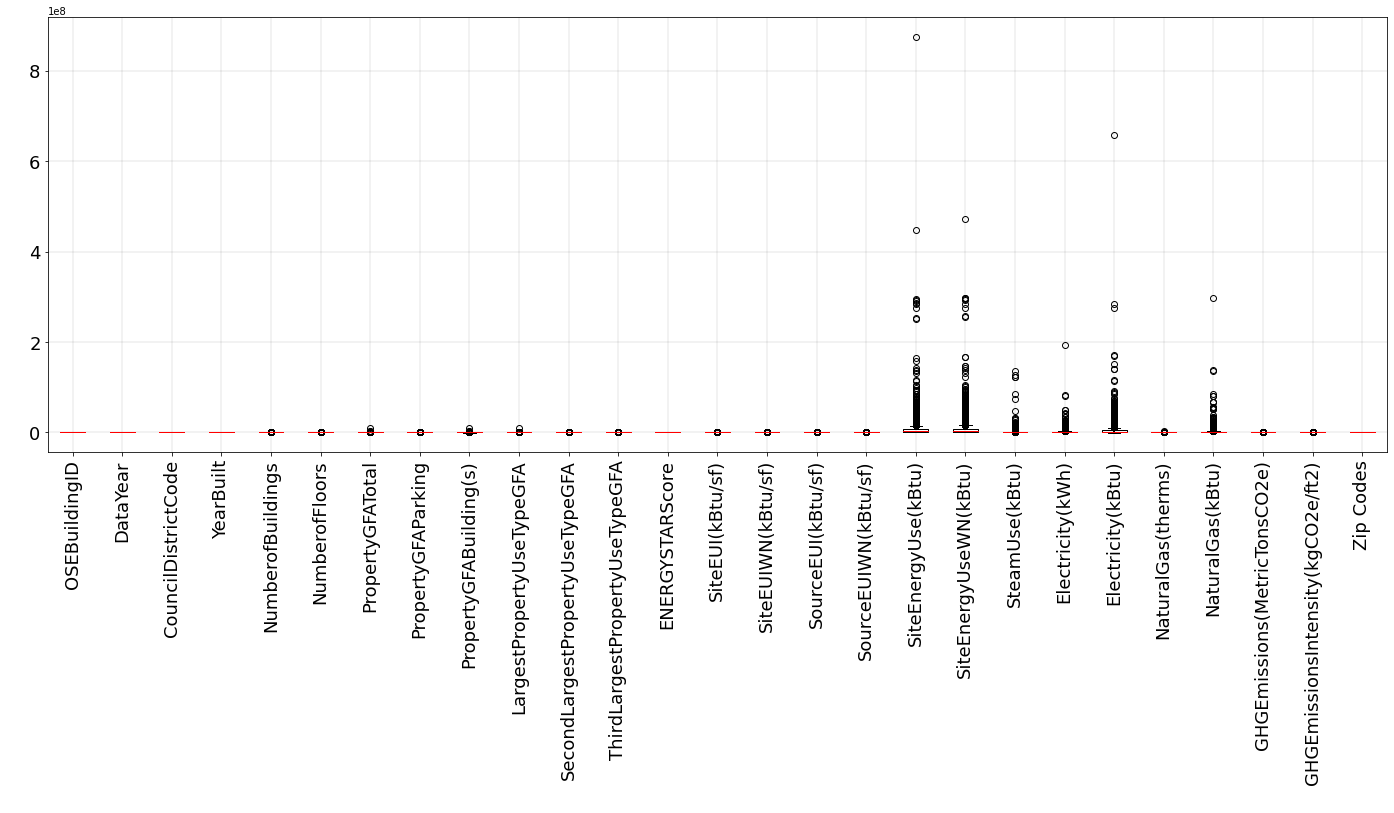

In [14]:
figure_name =Path(str(dir_fig) +'/'+ str('Initial_data.jpeg'))
ylabel = " "
xlabel = " "
ax = plot_box_plot(df,xlabel,ylabel,figure_name)

## Nettoyage des données

###  Traiter les doublons

In [15]:
df_final=copy.deepcopy(df)
df_dup = df_final.duplicated().sum()
if df_dup>0:
    df_final = df_final.drop_duplicates(inplace=True)
    print('Total doublons:  ',df_dup)

### Traiter les valeurs manquants

OSEBuildingID                           0
DataYear                                0
BuildingType                            0
PrimaryPropertyType                     0
PropertyName                            0
TaxParcelIdentificationNumber           1
CouncilDistrictCode                     0
Neighborhood                            0
YearBuilt                               0
NumberofBuildings                       2
NumberofFloors                          8
PropertyGFATotal                        0
PropertyGFAParking                      0
PropertyGFABuilding(s)                  0
ListOfAllPropertyUseTypes              63
LargestPropertyUseType                 71
LargestPropertyUseTypeGFA              71
SecondLargestPropertyUseType         1651
SecondLargestPropertyUseTypeGFA      1651
ThirdLargestPropertyUseType          2634
ThirdLargestPropertyUseTypeGFA       2634
YearsENERGYSTARCertified             3130
ENERGYSTARScore                      1107
SiteEUI(kBtu/sf)                  

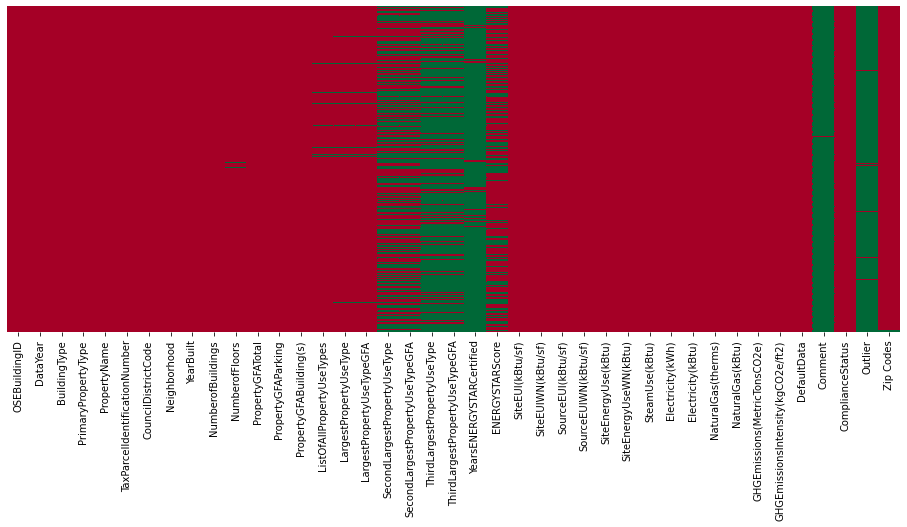

In [16]:
df_null = df_final.isnull().sum()
fig = plt.figure(figsize=(16,6))
sns.heatmap(df_final.isnull(),yticklabels=False,cbar=False, cmap='RdYlGn')
df_null 

In [17]:
define_max_acepteble_nan= 2     # 2 c'est la moitié de NaN or Nul
for col_name in df_final.columns:
    if df_null[col_name]>0:
        if df_null[col_name]> len(df_final)/define_max_acepteble_nan:
            print(col_name,df_null[col_name],len(df_final)/define_max_acepteble_nan)
            df_final=df_final.drop([col_name], axis=1)
        

ThirdLargestPropertyUseType 2634 1659.0
ThirdLargestPropertyUseTypeGFA 2634 1659.0
YearsENERGYSTARCertified 3130 1659.0
Comment 3306 1659.0
Outlier 3270 1659.0


In [18]:
df_null = df_final.isnull().sum()
df_null 

OSEBuildingID                           0
DataYear                                0
BuildingType                            0
PrimaryPropertyType                     0
PropertyName                            0
TaxParcelIdentificationNumber           1
CouncilDistrictCode                     0
Neighborhood                            0
YearBuilt                               0
NumberofBuildings                       2
NumberofFloors                          8
PropertyGFATotal                        0
PropertyGFAParking                      0
PropertyGFABuilding(s)                  0
ListOfAllPropertyUseTypes              63
LargestPropertyUseType                 71
LargestPropertyUseTypeGFA              71
SecondLargestPropertyUseType         1651
SecondLargestPropertyUseTypeGFA      1651
ENERGYSTARScore                      1107
SiteEUI(kBtu/sf)                       10
SiteEUIWN(kBtu/sf)                     10
SourceEUI(kBtu/sf)                      9
SourceEUIWN(kBtu/sf)              

In [19]:
df_final=df_final.dropna()
df_null =df_final.isnull().sum()
df_null

OSEBuildingID                        0
DataYear                             0
BuildingType                         0
PrimaryPropertyType                  0
PropertyName                         0
TaxParcelIdentificationNumber        0
CouncilDistrictCode                  0
Neighborhood                         0
YearBuilt                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
ListOfAllPropertyUseTypes            0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType         0
SecondLargestPropertyUseTypeGFA      0
ENERGYSTARScore                      0
SiteEUI(kBtu/sf)                     0
SiteEUIWN(kBtu/sf)                   0
SourceEUI(kBtu/sf)                   0
SourceEUIWN(kBtu/sf)                 0
SiteEnergyUse(kBtu)                  0
SiteEnergyUseWN(kBtu)    

###  Traiter les valeurs aberrants

In [20]:

q1value=0.25
q3value=0.75

q1 =df_final.quantile(q1value)
q3 =df_final.quantile(q3value)
iqr = q3-q1  
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
df_final = df_final[~((df_final < fence_low) |(df_final > fence_high)).any(axis=1)]

### Descriptive des donnée nettoyés

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 23 to 6687
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      566 non-null    float64
 1   DataYear                           566 non-null    float64
 2   BuildingType                       566 non-null    object 
 3   PrimaryPropertyType                566 non-null    object 
 4   PropertyName                       566 non-null    object 
 5   TaxParcelIdentificationNumber      566 non-null    object 
 6   CouncilDistrictCode                566 non-null    float64
 7   Neighborhood                       566 non-null    object 
 8   YearBuilt                          566 non-null    float64
 9   NumberofBuildings                  566 non-null    float64
 10  NumberofFloors                     566 non-null    float64
 11  PropertyGFATotal                   566 non-null    float

In [22]:
desc_final =df_final.describe()
desc_final

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Zip Codes
count,566.00,566.0,566.00,566.00,566.0,566.00,566.00,566.00,566.00,566.00,566.00,566.00,566.00,566.00,566.00,566.00,5.66e+02,5.66e+02,566.0,5.66e+02,5.66e+02,566.00,5.66e+02,566.00,566.00,566.00
mean,14814.05,2015.5,4.34,1963.15,1.0,3.26,68347.21,7796.44,60550.77,52151.90,15069.85,65.63,51.12,53.56,138.48,141.85,3.11e+06,3.23e+06,0.0,7.55e+05,2.58e+06,5364.30,5.36e+05,46.45,0.69,58584.44
std,12762.43,0.5,2.22,33.05,0.0,2.08,47994.31,14770.94,42692.43,39479.69,14475.38,26.84,24.02,24.98,71.24,72.12,2.77e+06,2.82e+06,0.0,7.77e+05,2.65e+06,7507.69,7.51e+05,44.37,0.63,39710.25
min,29.00,2015.0,1.00,1900.00,1.0,0.00,20140.00,-2.00,17824.00,8061.00,0.00,1.00,3.50,0.00,6.40,0.00,1.45e+05,0.00e+00,0.0,1.44e+04,4.90e+04,0.00,0.00e+00,1.58,0.01,17919.00
25%,577.00,2015.0,2.00,1938.75,1.0,2.00,32314.25,0.00,29832.25,24935.50,5884.00,50.00,34.00,36.20,83.62,86.75,1.15e+06,1.25e+06,0.0,2.43e+05,8.28e+05,0.00,0.00e+00,15.98,0.20,18388.00
50%,20827.00,2016.0,4.00,1970.00,1.0,3.00,52554.00,0.00,48258.50,38459.00,10408.00,72.00,49.25,52.10,135.40,137.55,2.23e+06,2.37e+06,0.0,5.04e+05,1.72e+06,2081.41,2.08e+05,31.93,0.46,98043.00
75%,24105.00,2016.0,7.00,1987.00,1.0,5.00,88000.00,11030.75,73452.25,67113.75,20300.75,87.00,65.20,68.98,181.88,186.15,4.29e+06,4.34e+06,0.0,1.05e+06,3.57e+06,7580.78,7.58e+05,59.21,1.00,98109.00
max,50081.00,2016.0,7.00,2015.00,1.0,12.00,291940.00,70067.00,291940.00,245240.00,100000.00,100.00,125.60,131.90,375.70,377.80,1.92e+07,1.92e+07,0.0,5.54e+06,1.89e+07,37494.99,3.75e+06,236.90,3.04,98199.00


### Supprimer les variables remplies de zéros

In [23]:
for k in desc_final.columns:
    if desc_final[k]['std']==0: 
        print(k)
        df_final=df_final.drop([k],axis=1) 


NumberofBuildings
SteamUse(kBtu)


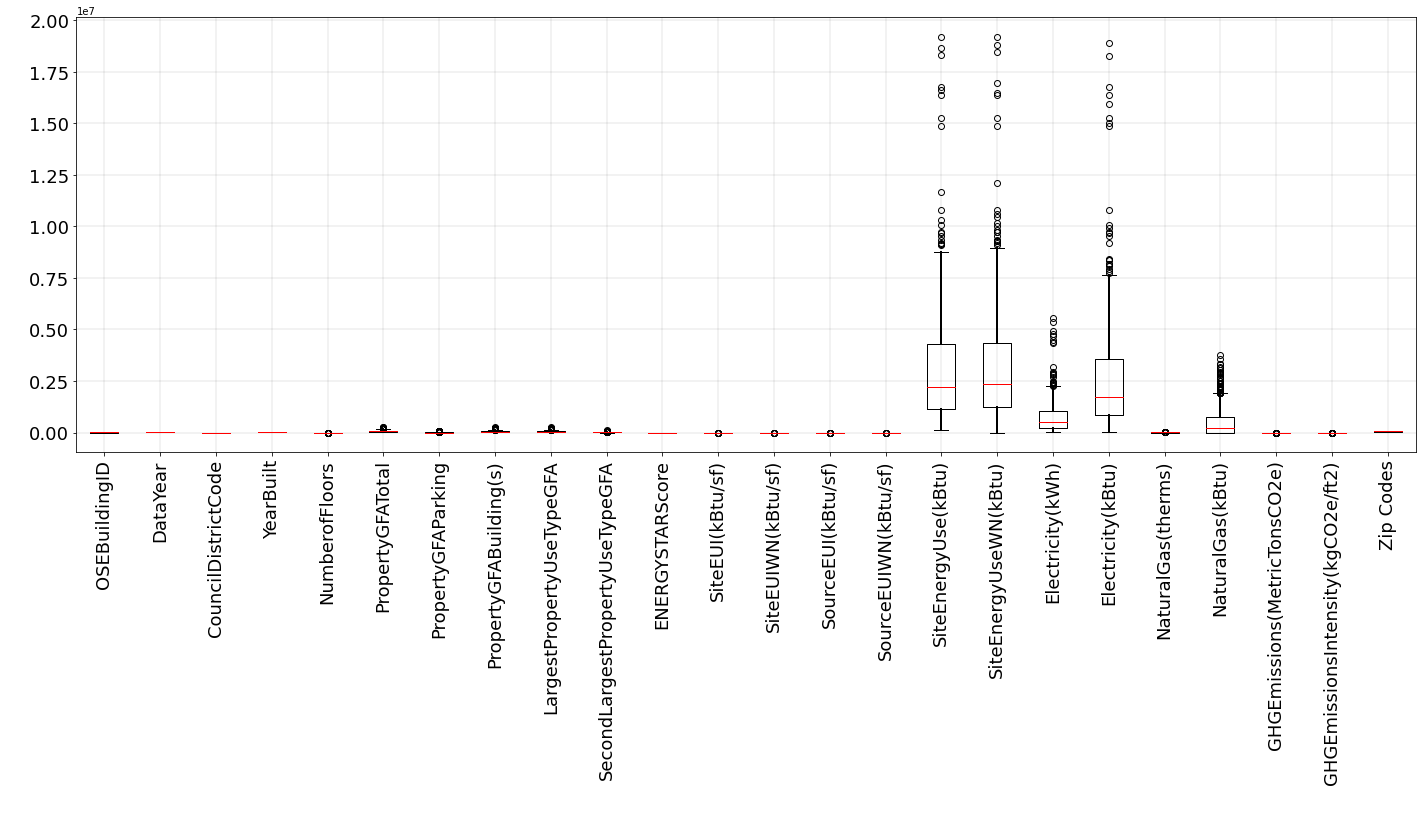

In [24]:
figure_name =Path(str(dir_fig) +'/' + str('Final_data.jpeg'))
ylabel = " "
xlabel = " "
ax = plot_box_plot(df_final,xlabel,ylabel,figure_name)

In [25]:
df_final.shape

(566, 34)

In [26]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 23 to 6687
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      566 non-null    float64
 1   DataYear                           566 non-null    float64
 2   BuildingType                       566 non-null    object 
 3   PrimaryPropertyType                566 non-null    object 
 4   PropertyName                       566 non-null    object 
 5   TaxParcelIdentificationNumber      566 non-null    object 
 6   CouncilDistrictCode                566 non-null    float64
 7   Neighborhood                       566 non-null    object 
 8   YearBuilt                          566 non-null    float64
 9   NumberofFloors                     566 non-null    float64
 10  PropertyGFATotal                   566 non-null    float64
 11  PropertyGFAParking                 566 non-null    float

In [27]:
# Convert date and date of build into building age
df_final['Building_age']=df_final['DataYear']-df_final['YearBuilt']

In [28]:
# Ces variables sont ID. Elles ne sont pas séquentielles (comme des séries chronologiques). Donc je peux supprimer.
df_final=df_final.drop(['OSEBuildingID'],axis=1)
df_final=df_final.drop(['CouncilDistrictCode'],axis=1)  
df_final=df_final.drop(['Zip Codes'],axis=1) 

In [29]:
# Separate into categorical and numerical variables
df_numerical  =df_final.select_dtypes(exclude='object')
df_categorical=df_final.select_dtypes(include='object')

In [30]:
df_numerical.isnull().sum()

DataYear                             0
YearBuilt                            0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseTypeGFA      0
ENERGYSTARScore                      0
SiteEUI(kBtu/sf)                     0
SiteEUIWN(kBtu/sf)                   0
SourceEUI(kBtu/sf)                   0
SourceEUIWN(kBtu/sf)                 0
SiteEnergyUse(kBtu)                  0
SiteEnergyUseWN(kBtu)                0
Electricity(kWh)                     0
Electricity(kBtu)                    0
NaturalGas(therms)                   0
NaturalGas(kBtu)                     0
GHGEmissions(MetricTonsCO2e)         0
GHGEmissionsIntensity(kgCO2e/ft2)    0
Building_age                         0
dtype: int64

# Analyse exploratoire

## Localisation géographique de Seattle et la distribution des batiments

In [31]:
lat = 47.6062095
lon = -122.3320708
SEA_map = folium.Map(location=[lat,lon],
                        zoom_start=11,
                        tiles='openstreetmap')
mc = MarkerCluster()
for index, row in Coordonee_geographique.iterrows():
    mc.add_child(folium.Marker(location=[str(row['Latitude']),    
                                          str(row['Longitude'])]))
SEA_map.add_child(mc)

max_CO2_emissions= Coordonee_geographique["GHGEmissions(MetricTonsCO2e)"].max() # max value as reference for the darkets shade GHGEmissions(MetricTonsCO2e)
HeatMap(data=Coordonee_geographique[['Latitude','Longitude', "GHGEmissions(MetricTonsCO2e)"]].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(),\
        min_opacity=0.2,max_val=max_CO2_emissions,radius=30, blur=20, max_zoom=10).add_to(SEA_map)

SEA_map


## Analyse univariée

In [32]:
def histplot_plot(fig,df_numerical,poss1,possi2,feat_idx):
    for feature in df_numerical.columns: 
        feat_idx=feat_idx
        ax = fig.add_subplot(poss1,possi2, (feat_idx+1))
        fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
        h = ax.hist(df_numerical[feature], bins=50, color='steelblue', density=True, edgecolor='none')
        ax.set_title(df_numerical.columns[feat_idx], fontsize=14)
        feat_idx=feat_idx+1
    

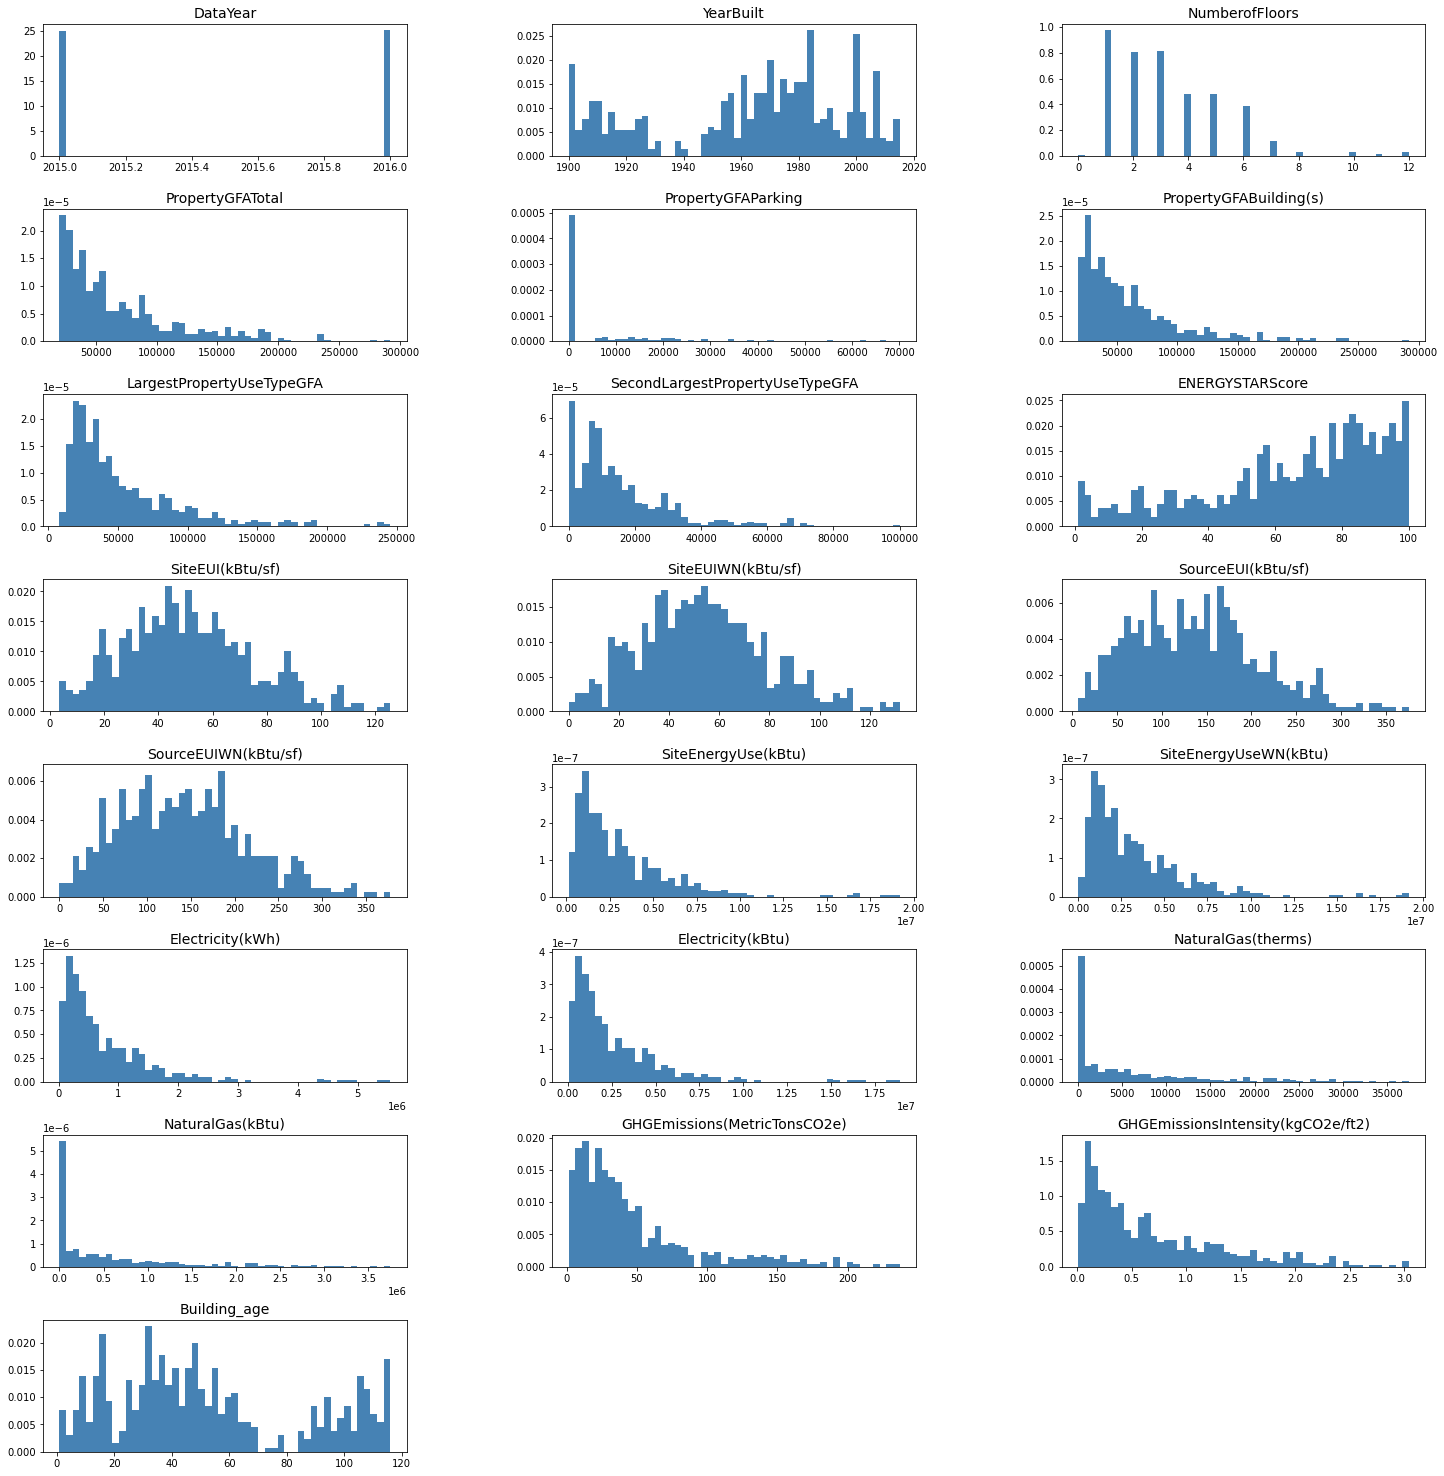

In [33]:
fig = plt.figure(figsize=(24, 28))
feat_idx=0
poss1=9
poss2=3

histplot_plot(fig,df_numerical,poss1,poss2,feat_idx)

Les données d'origine ne suivent pas la courbe gaussienne. Donc on doit les transformer en échelle logarithmique pour les rendre aussi "normales" que possible, de sorte que les résultats de l'analyse statistique de ces données soient plus valides. 

In [34]:
### Transform into log scale 
df_numerical=np.log(df_numerical+1)

In [35]:
df_numerical.isnull().sum()

DataYear                             0
YearBuilt                            0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   1
PropertyGFABuilding(s)               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseTypeGFA      0
ENERGYSTARScore                      0
SiteEUI(kBtu/sf)                     0
SiteEUIWN(kBtu/sf)                   0
SourceEUI(kBtu/sf)                   0
SourceEUIWN(kBtu/sf)                 0
SiteEnergyUse(kBtu)                  0
SiteEnergyUseWN(kBtu)                0
Electricity(kWh)                     0
Electricity(kBtu)                    0
NaturalGas(therms)                   0
NaturalGas(kBtu)                     0
GHGEmissions(MetricTonsCO2e)         0
GHGEmissionsIntensity(kgCO2e/ft2)    0
Building_age                         0
dtype: int64

In [36]:
df_numerical=df_numerical.dropna()

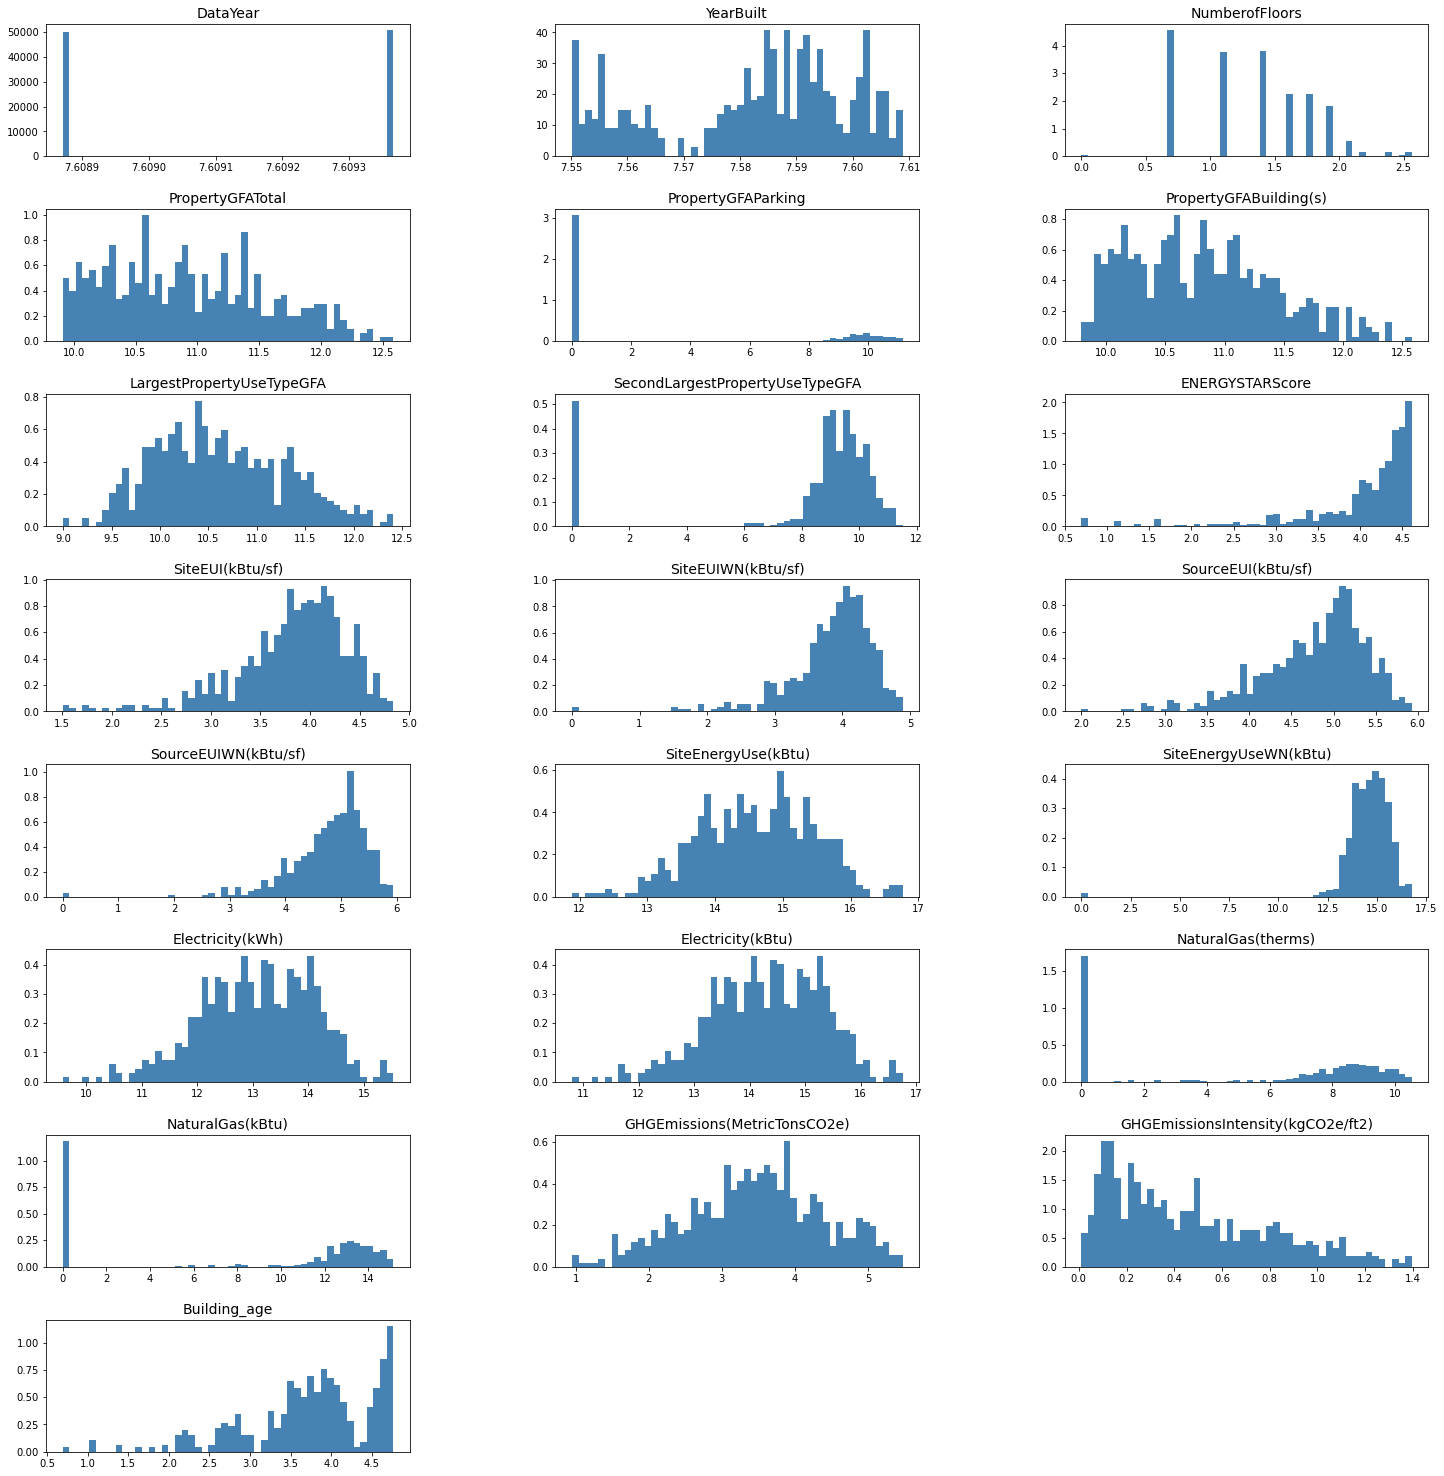

In [37]:
fig = plt.figure(figsize=(24, 28))
feat_idx=0
possi=8
possi2=3
histplot_plot(fig,df_numerical,poss1,possi2,feat_idx)
#

## Analyse bivariee

In [38]:
coef_correl=df_numerical.corr()
df_numerical.shape

(565, 22)

<AxesSubplot:>

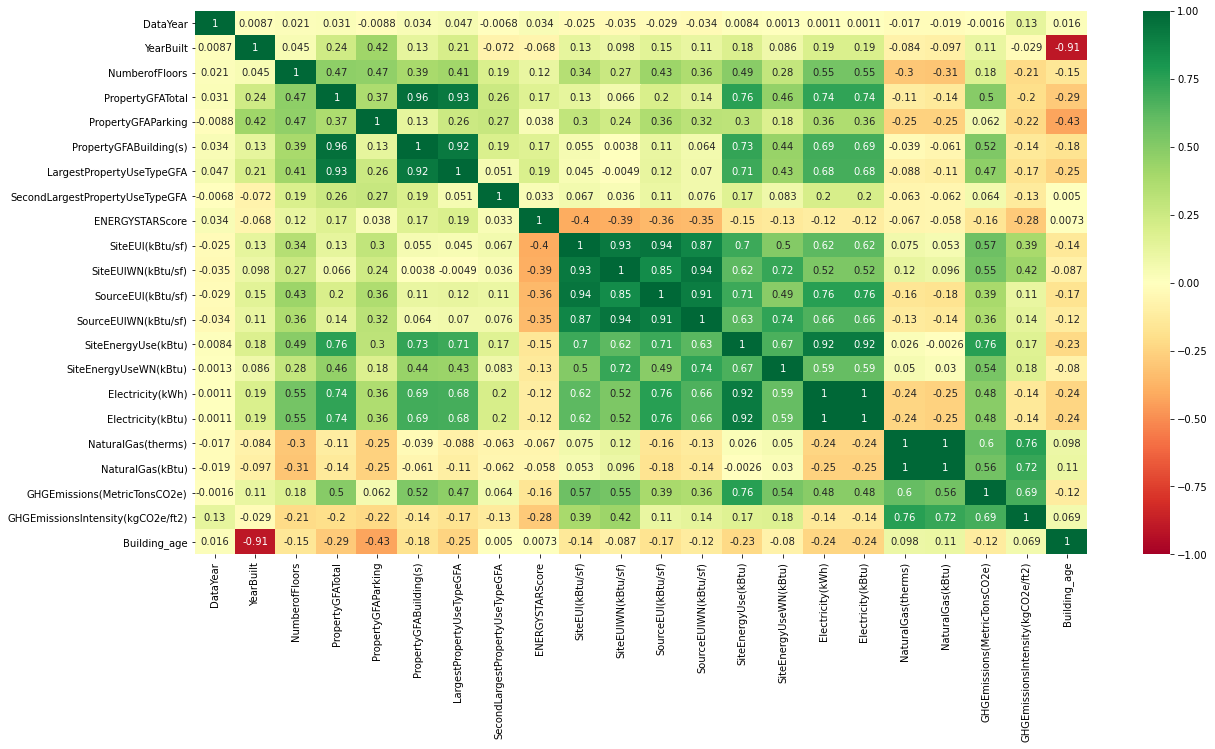

In [39]:
plt.figure(figsize=(20,10))
sns.heatmap(coef_correl, vmin=-1, vmax=1,  annot=True, cmap='RdYlGn')


Nous comparons la corrélation entre les caractéristiques et supprimons une des deux caractéristiques qui ont une corrélation supérieure à 0.9

In [40]:
columns = np.full((coef_correl.shape[0],), True, dtype=bool)
for i in range(coef_correl.shape[0]):
     for j in range(i+1, coef_correl.shape[0]):
        
        if abs(coef_correl.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
                        
selected_columns = df_numerical.columns[columns]
df_numerical= df_numerical[selected_columns] 
selected_columns.shape

(13,)

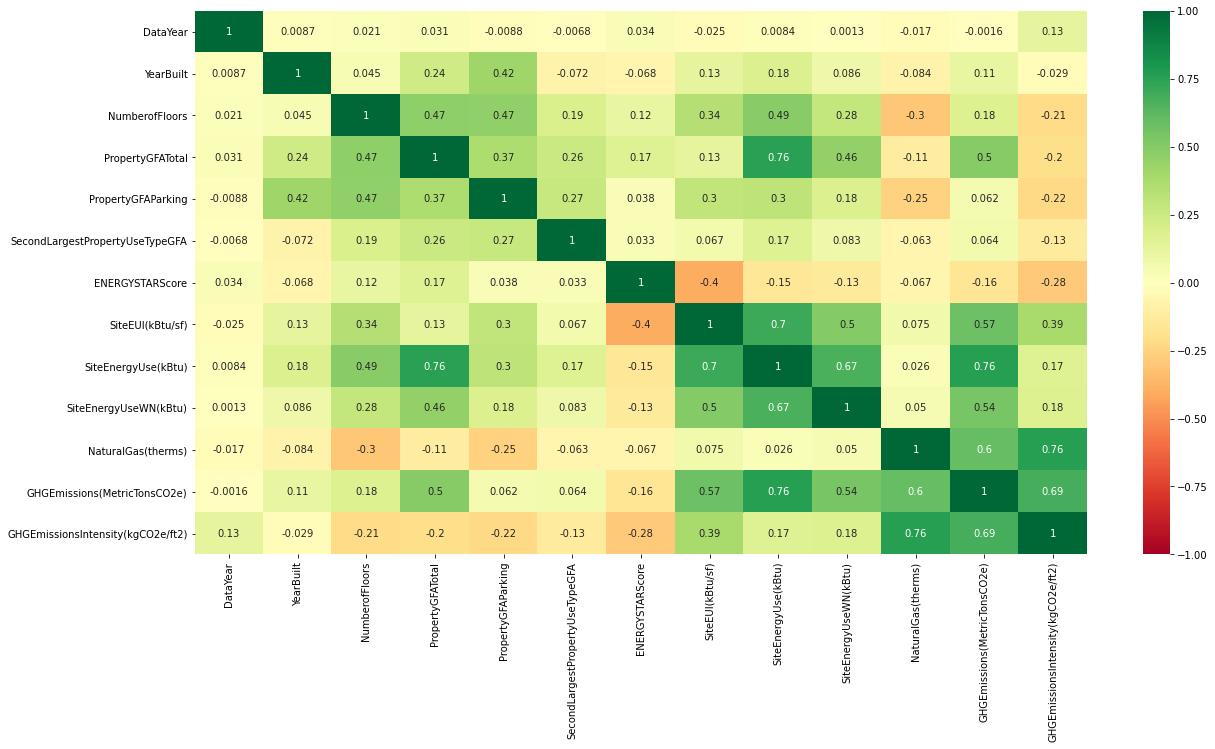

In [41]:
figure_name =Path(str(dir_fig) +'/' + str('correl.jpeg'))
coef_correl=df_numerical.corr()
plt.figure(figsize=(20,10))
sns.heatmap(coef_correl, vmin=-1, vmax=1,  annot=True, cmap='RdYlGn')
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

In [42]:
emission_correl=coef_correl['GHGEmissions(MetricTonsCO2e)']

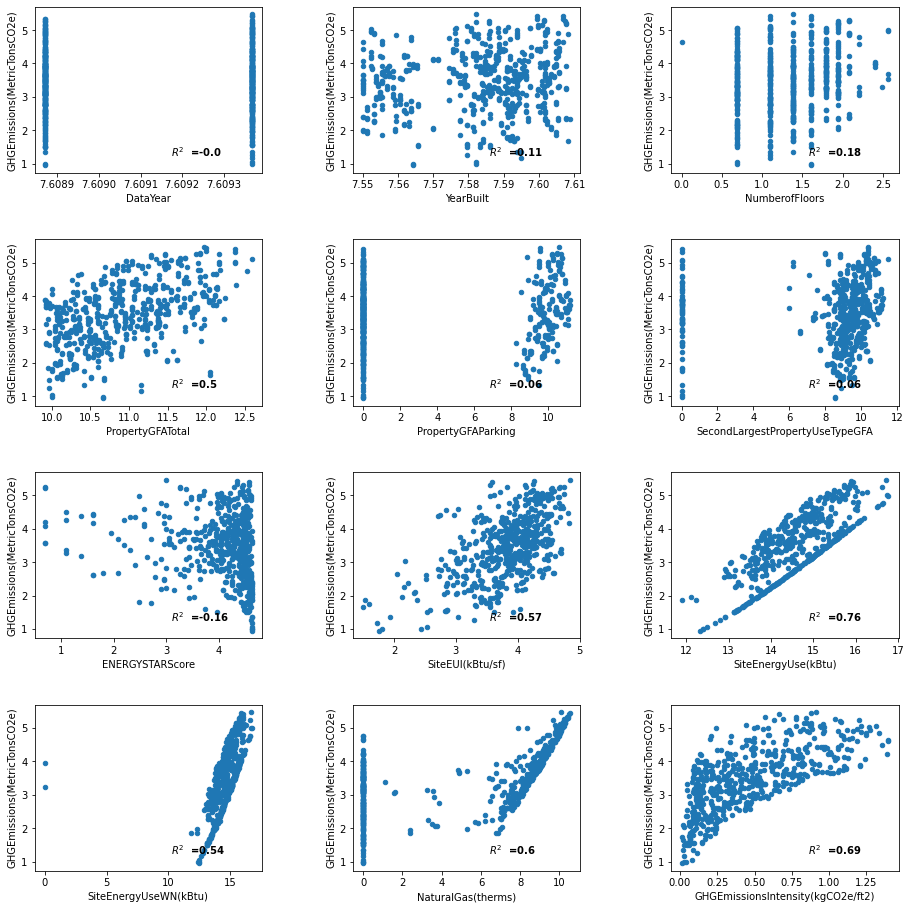

In [43]:
fig, axs = plt.subplots (4,3, figsize=(15, 15))
# set the spacing between subplots
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
ini =0
ini0=0

def plot_scatter_many(ini,ini0,df,xvar,yvar,corr):
    
    df_numerical.plot(kind='scatter',x=xvar,y=yvar,ax=axs[ini0,ini])
    axs[ini0,ini].text(.60,0.1,'$R^2$  =' + str(round(emission_correl[xvar],2)),
        horizontalalignment='left',
        transform=axs[ini0,ini].transAxes,weight="bold")
    ini=ini+1
    if ini==3:
        ini0=ini0+1
        ini =0
        
    
    return ini,ini0

yvar='GHGEmissions(MetricTonsCO2e)'
for col_name in df_numerical.columns:
    if col_name!=yvar:
        [ini,ini0]=plot_scatter_many(ini,ini0,df_numerical,col_name,yvar,emission_correl)


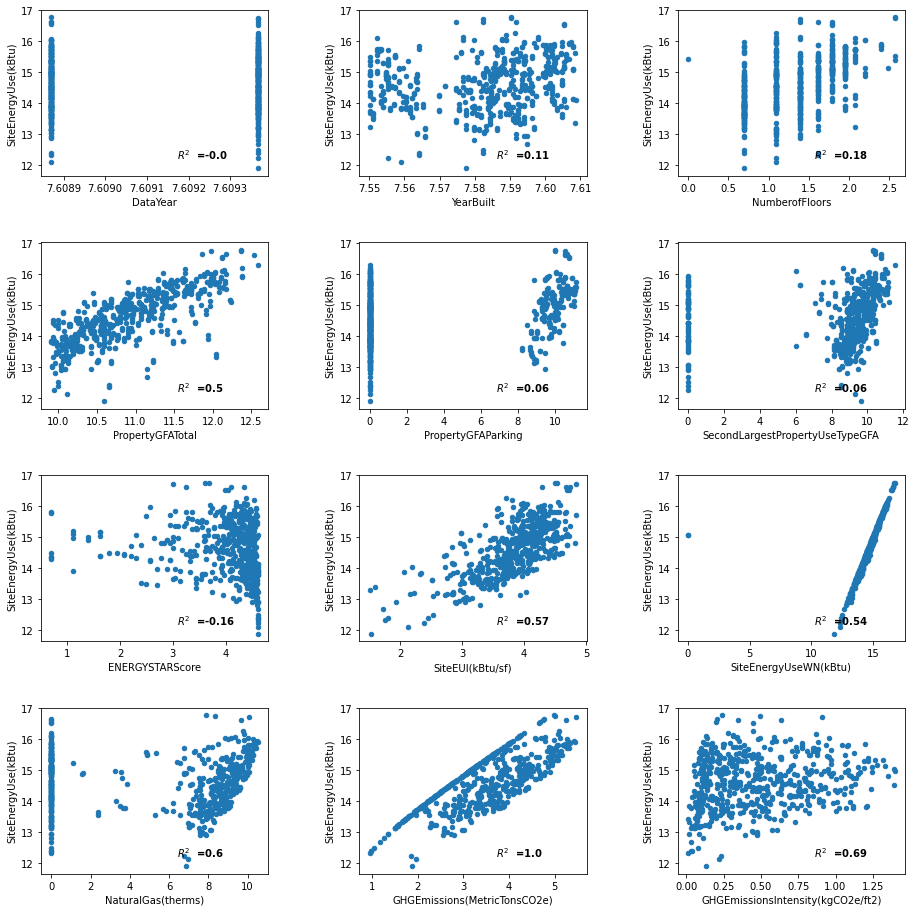

In [44]:
fig, axs = plt.subplots (4,3, figsize=(15, 15))
# set the spacing between subplots
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
ini =0
ini0=0

yvar='SiteEnergyUse(kBtu)'
for col_name in df_numerical.columns:
    if col_name!=yvar:
        [ini,ini0]=plot_scatter_many(ini,ini0,df_numerical,col_name,yvar,emission_correl)


DataYear a une faible relation avec SiteEnergyUseWN(kBtu) ou GHGEmissions(MetricTonsCO2e). Nous pouvons donc les supprimer 

In [45]:
df_numerical=df_numerical.drop('DataYear',axis=1)

In [46]:
df_numerical.to_csv(Numerical_data)
print ("Creater le fichier pour le projet ")
print(df_numerical.shape)

Creater le fichier pour le projet 
(565, 12)


In [47]:
df_numerical.isnull().sum()

YearBuilt                            0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
SecondLargestPropertyUseTypeGFA      0
ENERGYSTARScore                      0
SiteEUI(kBtu/sf)                     0
SiteEnergyUse(kBtu)                  0
SiteEnergyUseWN(kBtu)                0
NaturalGas(therms)                   0
GHGEmissions(MetricTonsCO2e)         0
GHGEmissionsIntensity(kgCO2e/ft2)    0
dtype: int64

## Transformation de données catégorielles en données continues

In [48]:
print(df_categorical.columns)
totransform=['Neighborhood' ]#,'BuildingType','PrimaryPropertyType','ListOfAllPropertyUseTypes', 'LargestPropertyUseType','SecondLargestPropertyUseType']
Cat_transformed=copy.deepcopy(df_categorical)
Cat_transformed.drop(Cat_transformed.columns.difference(totransform), 1, inplace=True )
feature_names=Cat_transformed.columns
index_garde=df_numerical.index
cat_index=Cat_transformed[totransform].index
diff_index=cat_index.difference(index_garde)
Cat_transformed=Cat_transformed.drop(index=diff_index)

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'Neighborhood',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'DefaultData', 'ComplianceStatus'],
      dtype='object')


In [49]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(Cat_transformed[totransform]).toarray(), index=Cat_transformed[totransform].index)

df_with_categorical = df_numerical.join(enc_df)

In [50]:
df_with_categorical.to_csv(Categorical_data)
print ("Creater le fichier pour le projet avec les variables categoriques")

Creater le fichier pour le projet avec les variables categoriques


In [51]:
full_df_cleaned=copy.deepcopy(df_numerical)
full_df_cleaned['Neighborhood']=df_categorical['Neighborhood']


14.609576424874954
0.46434435436870103
3.460315776022839
536430.7826855123
2576371.3886925797
1963.1537102473499


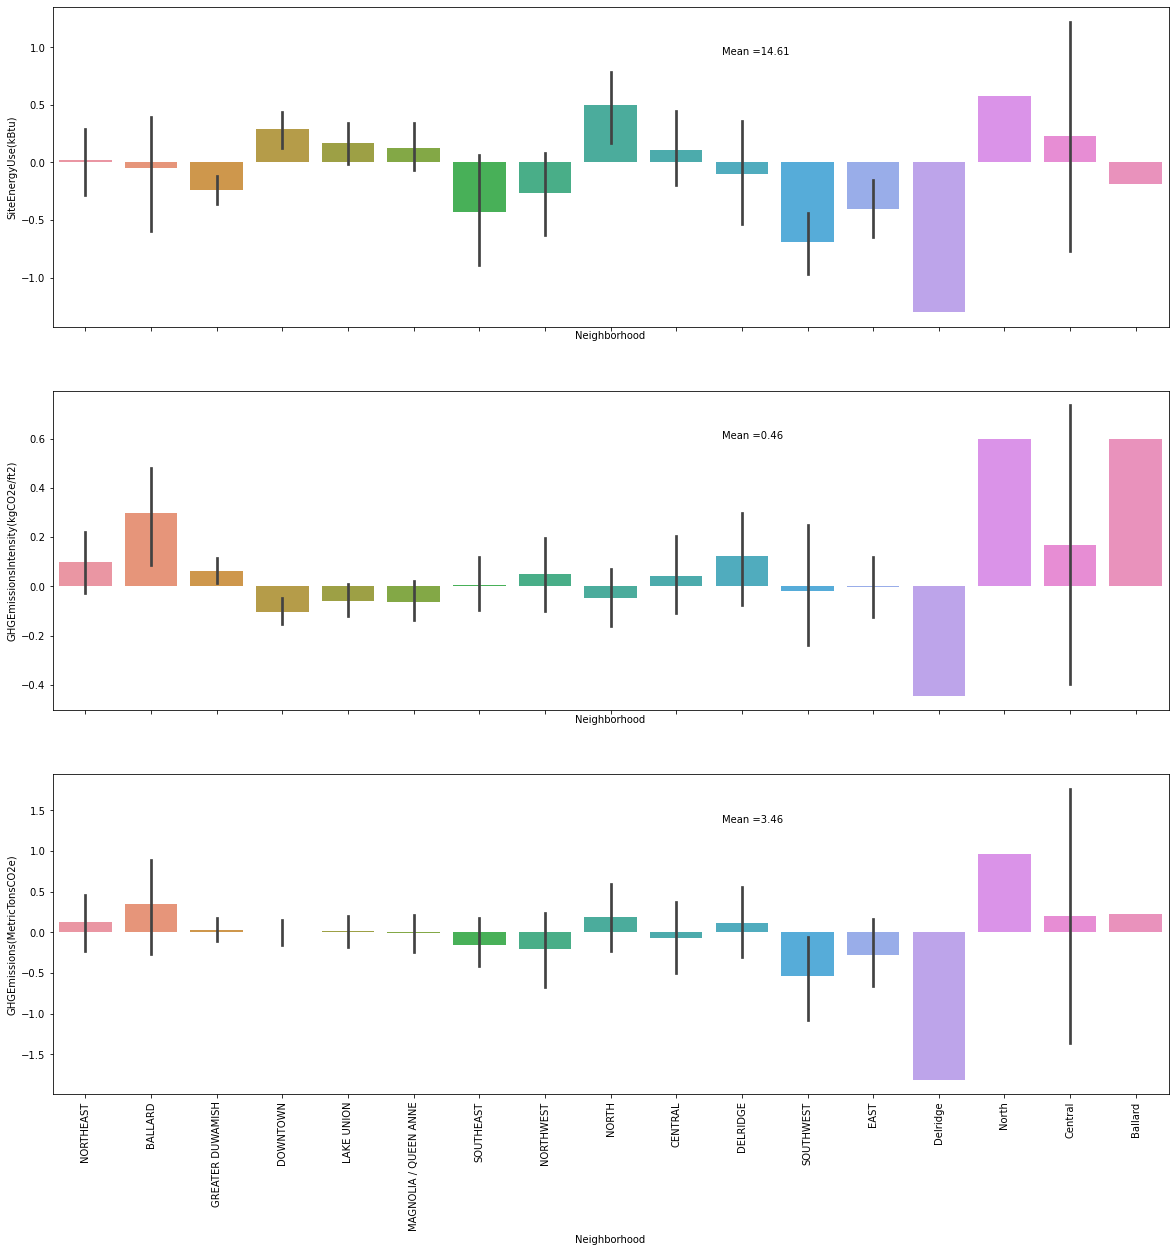

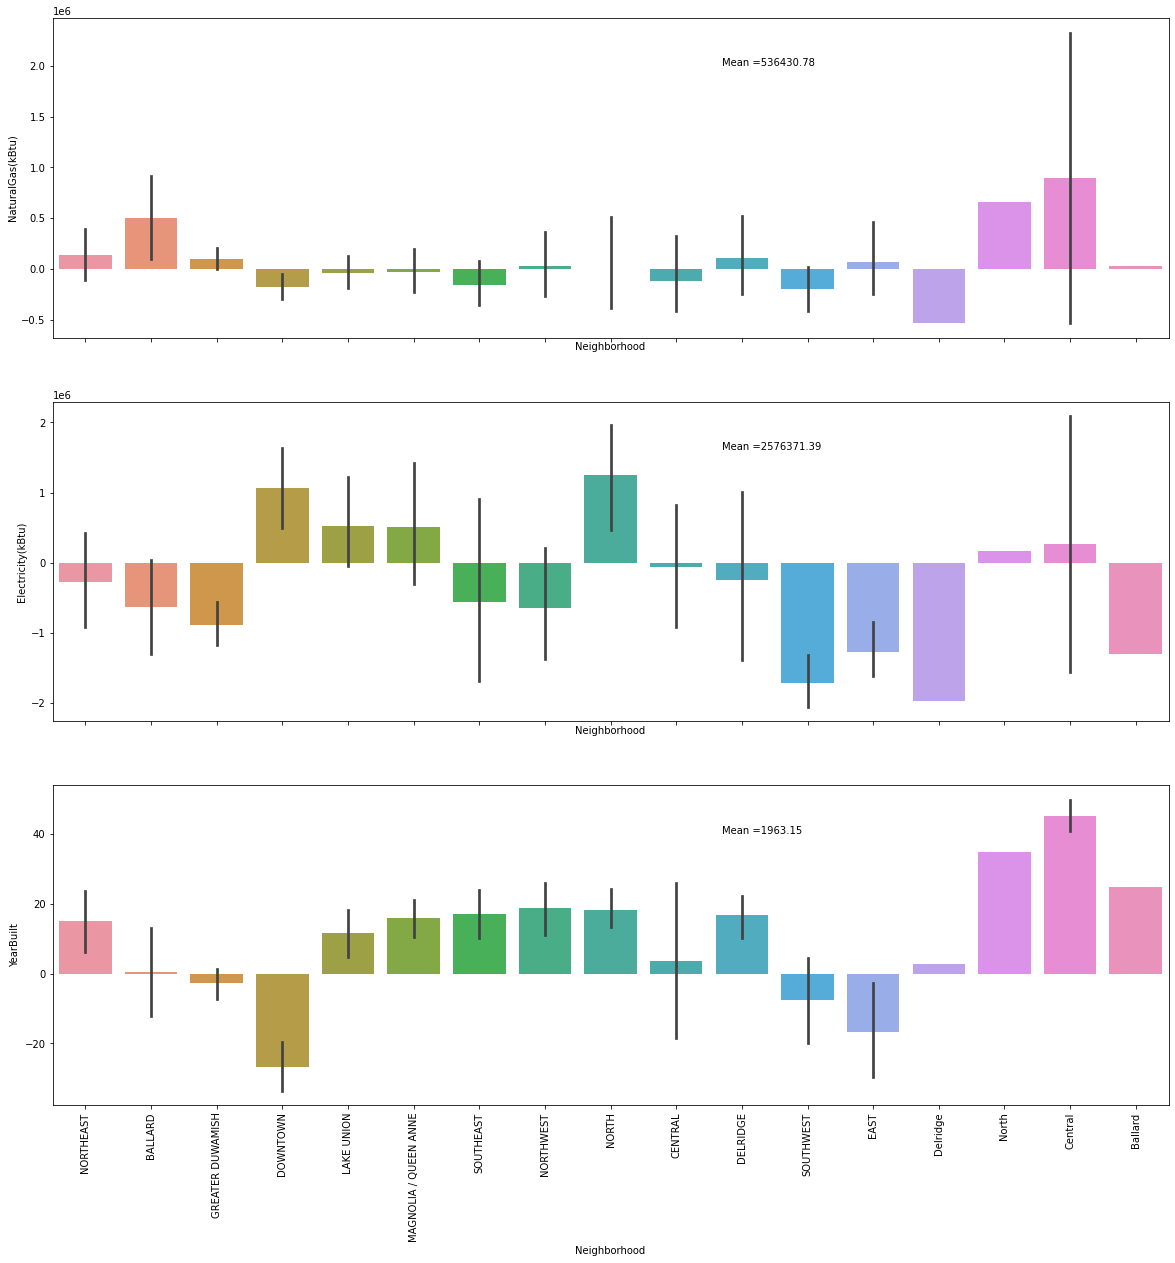

In [52]:
def bar_plot_chart(data_,x,y,axes,pos):
    var2keep=[x,y]
    data_.drop(data_.columns.difference(var2keep),1, inplace=True)
    mean_data=data_[y].mean()
    print(data_[y].mean())    
    data_[y]=data_[y]-data_[y].mean()
    chart =sns.barplot(x=x,y=y,data=data_,ax=axes[pos])
        
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    axes[pos].text(.60,0.85,'Mean =' + str(round(mean_data,2)),horizontalalignment='left',
                       transform=axes[pos].transAxes)
  #
figure_name =Path(str(dir_fig) +'/' + str('area_emission.jpeg'))
fig, axes = plt.subplots(3, sharex = True,figsize=(20,20))
bar_plot_chart(copy.deepcopy(full_df_cleaned),'Neighborhood','SiteEnergyUse(kBtu)',axes,0)
bar_plot_chart(copy.deepcopy(full_df_cleaned),'Neighborhood','GHGEmissionsIntensity(kgCO2e/ft2)',axes,1)
bar_plot_chart(copy.deepcopy(full_df_cleaned),'Neighborhood','GHGEmissions(MetricTonsCO2e)',axes,2)

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

figure_name =Path(str(dir_fig) +'/' + str('area_gas.jpeg'))
fig, axes = plt.subplots(3, sharex = True,figsize=(20,20))
bar_plot_chart(copy.deepcopy(df_final),'Neighborhood','NaturalGas(kBtu)',axes,0)
bar_plot_chart(copy.deepcopy(df_final),'Neighborhood','Electricity(kBtu)',axes,1)
bar_plot_chart(copy.deepcopy(df_final),'Neighborhood','YearBuilt',axes,2)

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
